In [42]:
import os, sys
proj_root = "/home/corcasta/projects/pandora_interview"
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

In [43]:
import torch
from models.tcn import TCNPredictor
import pandas as pd
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting import TimeSeriesDataSet

In [44]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_PATH = proj_root + "/data"

In [45]:
save_model_path = proj_root + "/models/weights/tcn_2025_05_04_11_11_35.pt"
model = TCNPredictor(input_size=13, seq_len=8, output_size=4).to(DEVICE)
model.load_state_dict(torch.load(save_model_path, weights_only=True))
model.eval()


TCNPredictor(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          13, 25, kernel_size=(4,), stride=(1,)
          (padder): TemporalPad1d(
            (pad): ConstantPad1d(padding=(3, 0), value=0.0)
          )
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          25, 25, kernel_size=(4,), stride=(1,)
          (padder): TemporalPad1d(
            (pad): ConstantPad1d(padding=(3, 0), value=0.0)
          )
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (downsam

In [46]:
valid_df = pd.read_csv(proj_root+"/data/valid_data.csv")

In [47]:
input_features = list(valid_df.columns.drop(["Product_ID", "Total_Amount", "Product_Category", "Time_Unitless"]))
feature_scalers = [None]*len(input_features)
scalers_dict = dict(zip(input_features, feature_scalers))


In [48]:
valid_df = pd.read_csv(DATASET_PATH + "/valid_data.csv")
valid_dataset = TimeSeriesDataSet(
    valid_df,
    time_idx="Time_Unitless",
    target="Total_Amount",
    target_normalizer=None,
    categorical_encoders={"Product_Category": NaNLabelEncoder().fit(valid_df.Product_Category)},
    group_ids=["Product_ID"],
    static_categoricals=["Product_Category"],
    time_varying_unknown_reals=["Total_Amount", *input_features],
    min_encoder_length=8,
    max_encoder_length=8,
    max_prediction_length=4,
    scalers=scalers_dict,
) 

valid_dataloader = valid_dataset.to_dataloader(batch_size=12)



In [49]:
def batch_preprocessing(x, y, batch_first=True):
    x_input = x["encoder_cont"]
    y_input = torch.squeeze(y[0])
    if batch_first == False:
        x_input = x_input.permute([1, 0, 2])
    return x_input.float(), y_input.float()

In [50]:
x, y = next(iter(valid_dataloader))


In [51]:
x["encoder_cont"].shape

# total_amount, Age, Male, Female, Quantity, price_per_unit, year, month, week, window_mean_4, window_mean5, window_mean_6, window_mean7, 

torch.Size([12, 8, 13])

In [52]:
x, y = batch_preprocessing(x,y)

In [53]:
x.dtype

torch.float32

In [54]:
output = model(x.to(DEVICE))

In [55]:
gt = y.cpu().detach().numpy()

In [56]:
pred = output.cpu().detach().numpy()

0


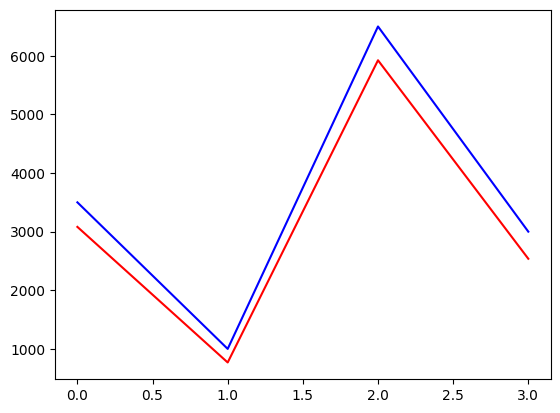

1


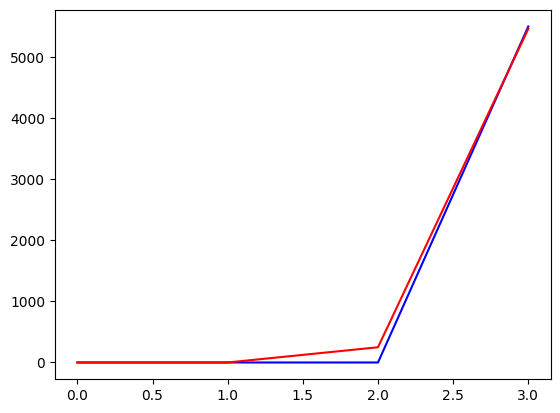

2


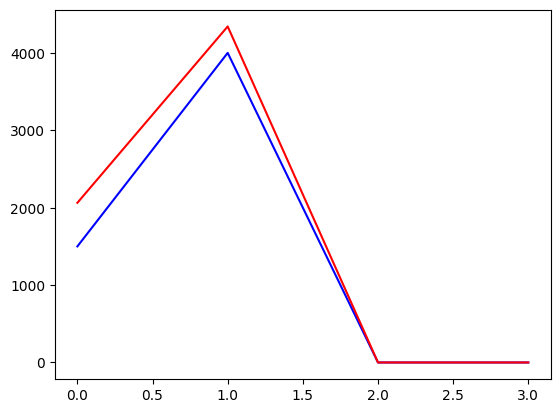

3


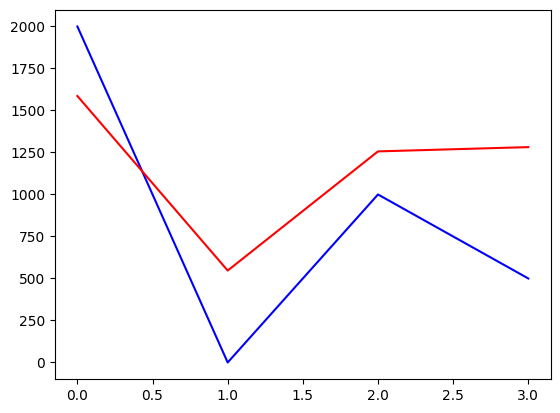

4


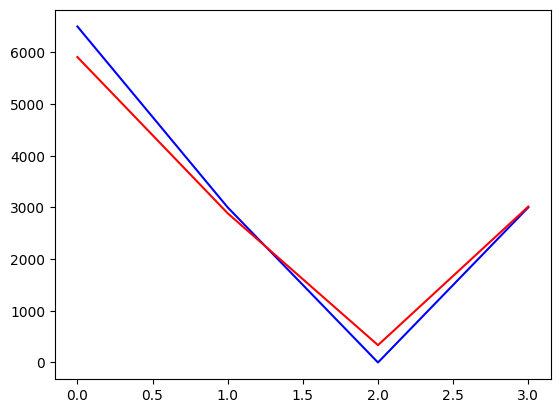

5


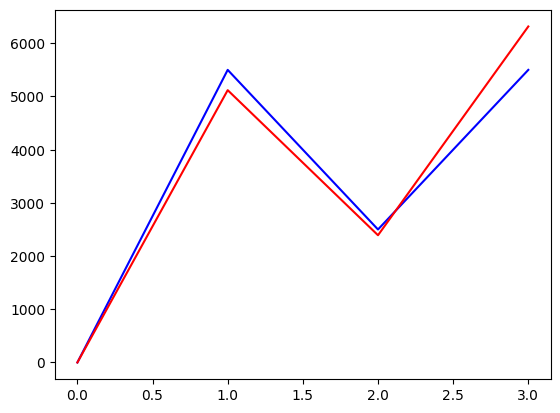

6


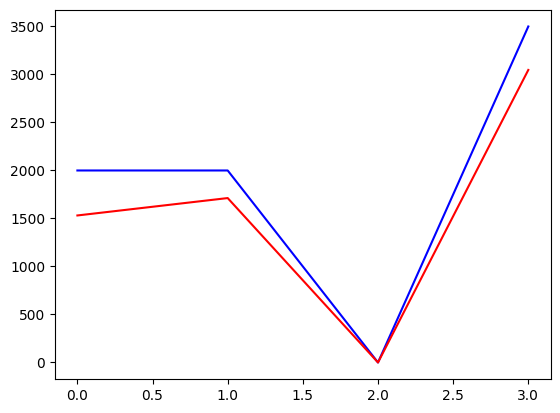

7


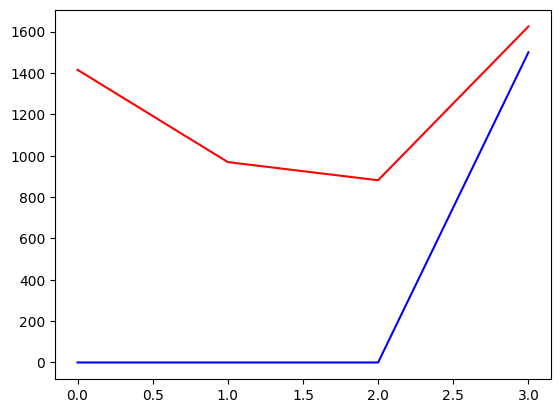

8


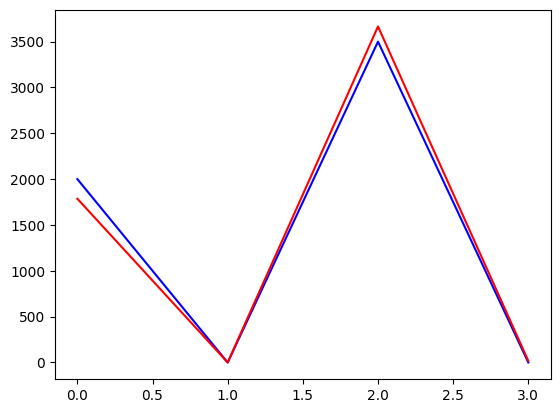

9


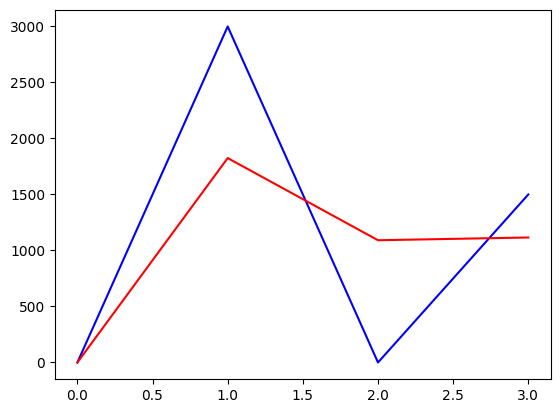

10


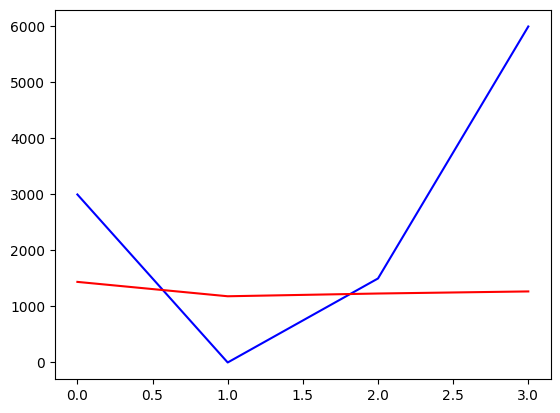

11


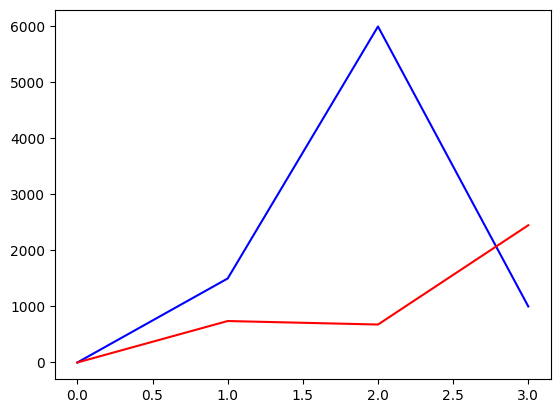

In [57]:
import matplotlib.pyplot as plt

for j in range(12):
    print(j)
    plt.plot([i for i in range(4)], gt[j,:], "b")
    plt.plot([i for i in range(4)], pred[j,:], "r")
    plt.show()

0


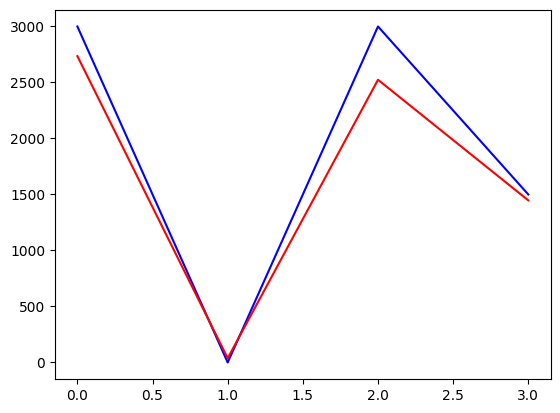

1


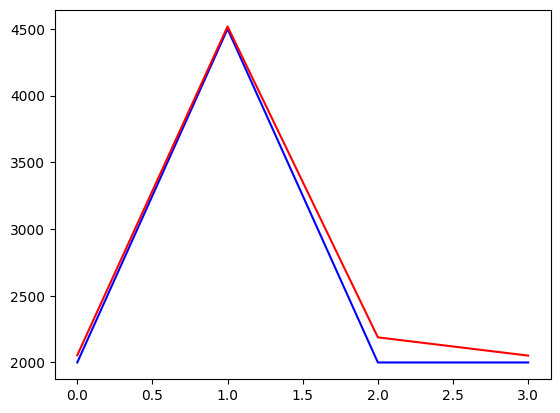

2


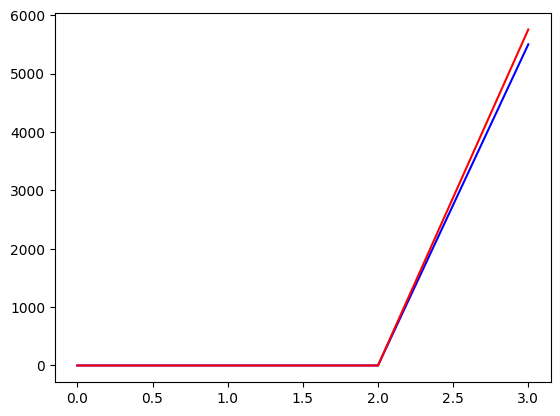

3


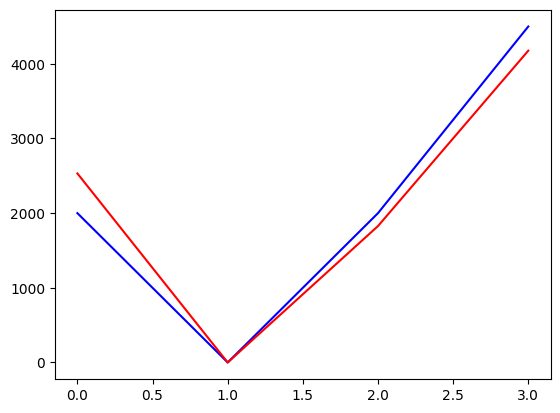

4


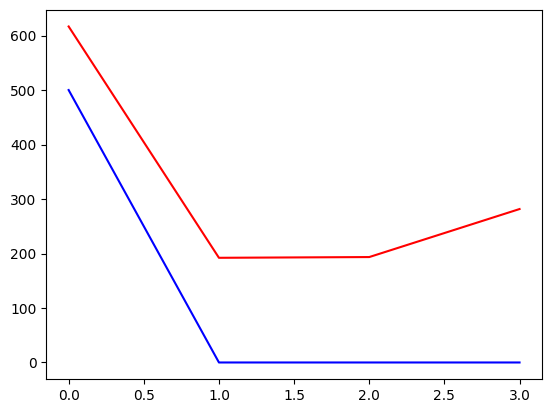

5


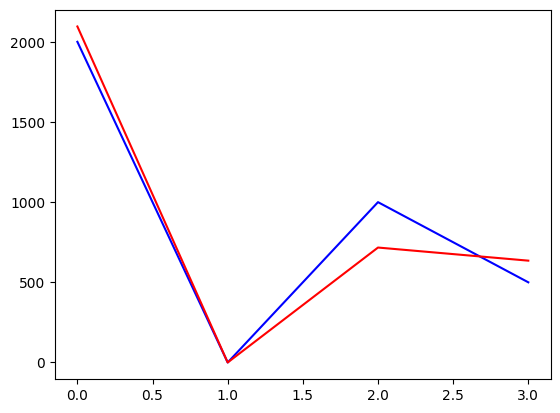

6


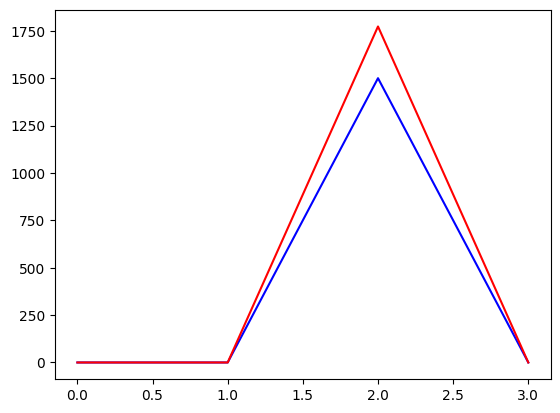

7


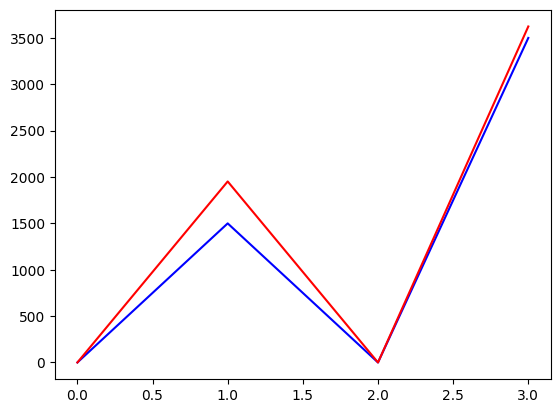

8


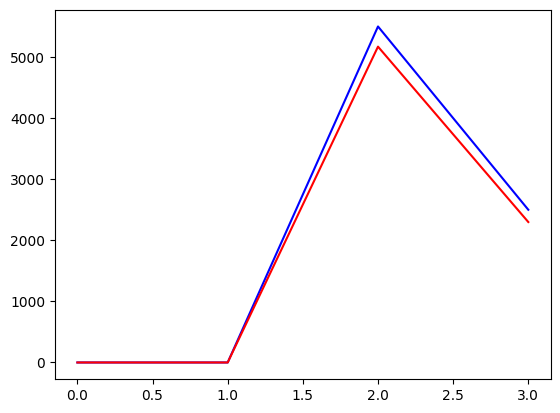

9


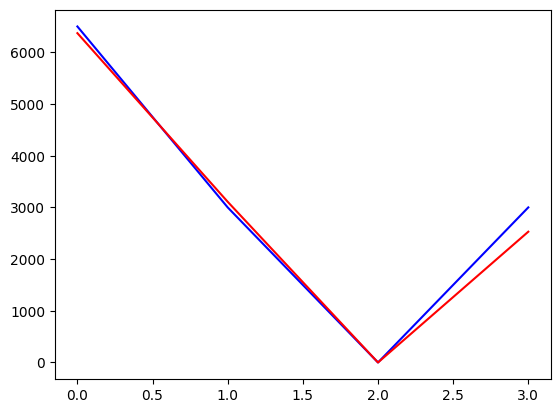

10


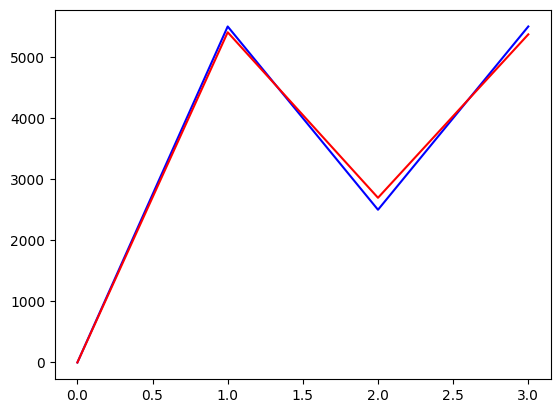

11


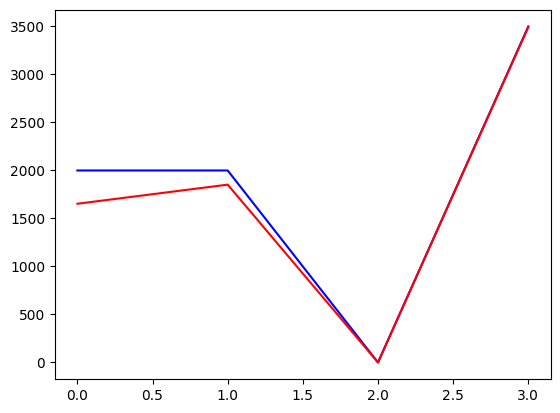

In [ ]:
import matplotlib.pyplot as plt

for j in range(12):
    print(j)
    plt.plot([i for i in range(4)], gt[j,:], "b")
    plt.plot([i for i in range(4)], pred[j,:], "r")
    plt.show()

In [84]:
df = pd.read_csv("/home/corcasta/projects/pandora_interview/data/sales_data.csv")

In [87]:
df[(df["Product Category"] == "Electronics") & (df["Price per Unit"] == 30)]

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
28,29,2023-08-18,CUST029,Female,42,Electronics,1,30,30
44,45,2023-07-03,CUST045,Female,55,Electronics,1,30,30
65,66,2023-04-27,CUST066,Female,45,Electronics,1,30,30
72,73,2023-08-21,CUST073,Male,29,Electronics,3,30,90
...,...,...,...,...,...,...,...,...,...
956,957,2023-08-15,CUST957,Female,60,Electronics,4,30,120
958,959,2023-10-29,CUST959,Female,42,Electronics,2,30,60
980,981,2023-08-19,CUST981,Female,30,Electronics,2,30,60
991,992,2023-08-21,CUST992,Female,57,Electronics,2,30,60


In [77]:
df_a = df_test[df_test["Product_ID"]==0][:8]
df_b = df_test[df_test["Product_ID"]==1][:8]

In [81]:
pd.concat([df_a,df_b]).to_csv("/home/corcasta/projects/pandora_interview/data/inference_dummy.csv", index=False)

In [17]:
import json
import requests
# 1) Define your endpoint
url = "http://localhost:8000/predict"

# 2) Prepare any extra form fields you want to send alongside the file
data = {
    'metadata': json.dumps({"product_id": [1]})
}

# 3) Open your CSV and prepare the files dict
files = {
    # field name "file" must match what decode_request() expects
    "file": (
        "data.csv",             # filename reported to the server
        open("/home/corcasta/projects/pandora_interview/data/sales_data.csv", "rb"), # file handle
        "text/csv"              # content type
    )
}

# 4) Send the POST
response = requests.post(url, data=data, files=files)
json.loads(response.content)

{'1': {'week_0': '61.450638',
  'week_1': '109.70733',
  'week_2': '61.97812',
  'week_3': '0.0'}}

In [9]:
def df_preprocessing(df):
    # Renaming Columns
    new_column_names = []
    for name in df.columns:
        new_column_names.append(name.replace(" ", "_"))    
    df.columns = new_column_names

    # This list will help map unique products to an ID.
    unique_products_list = []
    for category in sorted(df["Product_Category"].unique()):
        for price in sorted(df[df["Product_Category"] == category]["Price_per_Unit"].unique()):
            unique_products_list.append((category, price))

    for gender in ["Male", "Female"]:
        df[gender] = (df["Gender"] == gender).astype(int)
            
    df["Product_ID"] = 0
    df_prods_list = []
    agg_dict = {
        "Age": "median",
        "Male": "sum",
        "Female": "sum",
        "Quantity": "sum",
        "Total_Amount": "sum"
    }
    for id, (category, price) in enumerate(unique_products_list):
        df_product = df.loc[(df["Product_Category"] == category) & (df["Price_per_Unit"] == price)].sort_values(by=["Date"])
        df_product = df_product.groupby([pd.Grouper(key="Date", freq="W-Mon")]).agg(agg_dict).reset_index()
        
        df_product["Product_ID"] = id
        df_product["Product_Category"] = category
        df_product["Price_per_Unit"] = price
        df_product = df_product.fillna(0)
        
        df_product["Time_Unitless"] = [i for i in range(len(df_product))]
        df_product["Year"] = df_product["Date"].dt.year
        df_product["Month"] = df_product["Date"].dt.month
        df_product["Week"] = df_product["Date"].dt.isocalendar().week
        df_product.pop("Date")
        
        individual_windows = 4
        
        window_columns = []
        for window in range(4, individual_windows+4):
            df_product[f"Window_Mean_{window}"] = df_product["Total_Amount"].rolling(window, ).mean().bfill().ffill().round(2)
            window_columns.append(f"Window_Mean_{window}")
        
        df_prods_list.append(df_product)
    return pd.concat(df_prods_list, ignore_index=True)
    

In [13]:
df_test = pd.read_csv("/home/corcasta/projects/pandora_interview/data/sales_data.csv")

In [16]:
df_test["Date"] = pd.DatetimeIndex(df_test["Date"])

In [45]:
df_test = df_preprocessing(df_test)

In [46]:
df_test[df_test["Product_ID"].isin([0,1])]

,Age,Male,Female,Quantity,Total_Amount,Product_ID,Product_Category,Price_per_Unit,Time_Unitless,Year,Month,Week,Window_Mean_4,Window_Mean_5,Window_Mean_6,Window_Mean_7
0,19.0,0,1,1,25,0,Beauty,25,0,2023,1,1,81.25,80.0,70.83,78.57
1,19.0,1,0,2,50,0,Beauty,25,1,2023,1,2,81.25,80.0,70.83,78.57
2,34.0,1,2,10,250,0,Beauty,25,2,2023,1,3,81.25,80.0,70.83,78.57
3,0.0,0,0,0,0,0,Beauty,25,3,2023,1,4,81.25,80.0,70.83,78.57
4,23.0,0,1,3,75,0,Beauty,25,4,2023,1,5,93.75,80.0,70.83,78.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,40.0,0,2,5,150,1,Beauty,30,46,2023,11,48,112.50,108.0,90.00,94.29
99,0.0,0,0,0,0,1,Beauty,30,47,2023,12,49,112.50,90.0,90.00,77.14
100,33.5,2,0,5,150,1,Beauty,30,48,2023,12,50,112.50,120.0,100.00,98.57
101,52.0,0,1,2,60,1,Beauty,30,49,2023,12,51,90.00,102.0,110.00,94.29


In [60]:
import numpy as np

In [66]:
arrays[1].shape

(1, 51, 13)

In [68]:
cols = [
    "Total_Amount", "Age", "Male", "Female", "Quantity",
    "Price_per_Unit", "Year", "Month", "Week",
    "Window_Mean_4", "Window_Mean_5", "Window_Mean_6", "Window_Mean_7"
]

arrays = []
for id in [0,1]:
    df_id = df_test.loc[df_test["Product_ID"] == id, cols]
    arr = df_id.iloc[-8:,:].to_numpy()[np.newaxis,:,:]
    arrays.append(arr)
x = np.concatenate(arrays, axis=0)
x.shape

(2, 8, 13)

In [227]:
df_test.to_csv("/home/corcasta/projects/pandora_interview/data/sales_data.csv", index=False)

In [223]:
unique_products = [('Beauty', 25), ('Beauty', 30), ('Beauty', 50), ('Beauty', 300), ('Beauty', 500), ('Clothing', 25), ('Clothing', 30), ('Clothing', 50), ('Clothing', 300), ('Clothing', 500), ('Electronics', 25), ('Electronics', 30), ('Electronics', 50), ('Electronics', 300), ('Electronics', 500)]
unique_product_map = {}
for i, up in enumerate(unique_products):
    unique_product_map[up] = i 


In [21]:
ID_MAP = {
    ('Beauty', 25): 0,
    ('Beauty', 30): 1,
    ('Beauty', 50): 2,
    ('Beauty', 300): 3,
    ('Beauty', 500): 4,
    ('Clothing', 25): 5,
    ('Clothing', 30): 6,
    ('Clothing', 50): 7,
    ('Clothing', 300): 8,
    ('Clothing', 500): 9,
    ('Electronics', 25): 10,
    ('Electronics', 30): 11,
    ('Electronics', 50): 12,
    ('Electronics', 300): 13,
    ('Electronics', 500): 14
 }

ID_MAP.keys()

dict_keys([('Beauty', 25), ('Beauty', 30), ('Beauty', 50), ('Beauty', 300), ('Beauty', 500), ('Clothing', 25), ('Clothing', 30), ('Clothing', 50), ('Clothing', 300), ('Clothing', 500), ('Electronics', 25), ('Electronics', 30), ('Electronics', 50), ('Electronics', 300), ('Electronics', 500)])